![](https://i.imgur.com/gLH0p3a.jpg)

I'm going to use the New York Stock Exchange database in order to predict General Eletric's stock price in 30 days (buy or sell) from the 60 previous days worth of data from companies in the S&P500. 

 1. [LSTM]()
 2. [LSTM + GRU]()
 3. [Attention]()
 4. [Multi-Head Attention]()

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['securities.csv', 'fundamentals.csv', 'prices-split-adjusted.csv', 'prices.csv']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("../input/prices.csv")

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null datetime64[ns]
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 45.5+ MB


In [5]:
df.head(20)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
5,2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
6,2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
7,2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
8,2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0
9,2016-01-19,WLTW,113.660004,110.379997,109.870003,115.870003,1523500.0


In [6]:
 df_pivot = df.pivot('date','symbol','close').reset_index()
 df_pivot.head()

symbol,date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALK,ALL,ALLE,ALXN,AMAT,AME,AMG,AMGN,AMP,AMT,AMZN,AN,ANTM,...,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WFM,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
0,2010-01-04,31.300001,4.77,40.380001,214.009998,NaN,26.629999,54.459951,42.070000,37.090000,31.670000,31.469999,42.830002,65.889999,25.670000,27.760000,34.939999,13.67,33.000000,47.570000,40.290001,29.889999,15.960000,30.160000,22.330000,25.920000,38.090000,34.869999,30.410000,NaN,48.250000,14.30,38.600000,68.879997,57.720001,39.880001,43.459999,133.899994,19.270000,59.750000,...,47.169998,73.379997,29.980000,17.889997,52.730000,70.019993,29.850000,24.740000,44.240002,43.349998,33.279869,61.630001,37.299999,45.259998,49.730000,27.320000,27.850000,81.949997,NaN,34.160000,21.609949,54.230000,NaN,19.090000,44.279999,20.280001,63.959999,55.169998,21.080000,18.719999,25.379999,69.150002,35.330002,8.63,NaN,17.100000,35.090001,60.020000,13.33,NaN
1,2010-01-05,30.960001,5.31,40.139999,214.379993,NaN,26.440001,54.019953,42.330002,37.700001,31.620001,31.639999,42.600003,66.019997,25.280001,27.650000,34.540001,13.53,32.529999,48.950001,39.889999,29.330000,16.360001,31.059999,22.209999,26.690001,38.020000,36.779999,30.910000,NaN,47.560001,14.19,38.430000,69.430000,57.220001,40.810001,44.180000,134.690002,19.570000,60.400002,...,47.840000,74.779999,30.040001,18.350001,52.930000,69.489998,30.049999,25.000000,42.779999,43.560001,33.339868,60.790001,37.000000,46.459999,49.080002,28.070000,27.620001,81.779999,NaN,34.009998,21.879956,53.689999,NaN,19.010000,45.220001,20.709999,67.849998,55.070000,20.830000,18.590000,25.059999,69.419998,34.910000,8.64,NaN,17.230000,34.970000,61.919998,13.80,NaN
2,2010-01-06,30.850001,5.09,40.490002,210.969995,NaN,26.190001,54.319953,42.779999,37.619999,31.559999,31.559999,42.500004,66.349998,25.340000,27.459999,34.889999,13.39,32.400002,49.380001,40.020000,29.139999,16.650000,30.969999,22.219999,26.469999,38.090000,36.450001,30.920000,NaN,47.680000,14.16,38.470001,70.790001,56.790001,41.380001,44.410000,132.250000,20.320000,61.380001,...,48.130001,74.480003,29.889999,18.809996,53.849998,69.210001,30.440001,24.730000,42.029999,43.070000,31.919873,60.900002,36.720001,46.500000,49.580002,28.110001,27.940001,81.059998,NaN,34.000000,22.589952,53.570000,NaN,19.000000,44.720001,21.100000,66.959999,54.990002,20.870001,18.400000,24.889999,70.019997,35.139999,8.56,NaN,17.170000,34.720002,61.900002,15.00,NaN
3,2010-01-07,30.809999,5.24,40.480000,210.580000,NaN,25.770000,54.769952,42.740002,36.889999,31.309999,31.230000,42.480000,66.959999,25.480000,27.200001,35.189999,13.40,33.430000,49.910000,39.700001,28.580000,17.260000,31.350000,22.080000,26.480000,37.820000,36.259998,31.080000,NaN,47.860001,14.01,38.569998,70.470001,56.270000,41.689999,44.290001,130.000000,20.680000,63.660000,...,47.340000,75.919998,30.200001,18.950005,53.169998,70.279998,30.389999,24.389999,41.500000,43.549999,31.729875,61.160000,36.939999,45.590000,49.480000,29.129999,27.820000,82.800003,NaN,34.080002,22.429955,53.599998,NaN,19.610001,44.520000,21.070000,68.389999,54.119999,20.780001,18.400000,24.639999,69.800003,35.599998,8.60,NaN,16.700001,34.710002,63.320000,16.68,NaN
4,2010-01-08,30.800000,5.14,40.639999,211.980005,NaN,26.049999,55.049952,42.570000,36.689999,31.490000,30.840000,42.420001,67.680000,26.260000,27.010000,35.610001,13.78,32.700001,49.410000,39.410000,29.340000,16.860001,31.370001,22.139999,26.480000,38.389999,35.540001,31.209999,NaN,47.950001,14.55,39.320000,69.820000,56.770000,41.840000,44.380001,133.520004,20.690001,63.939999,...,47.389999,75.519997,30.040001,18.690006,52.650002,69.500000,30.000000,24.580000,40.669998,43.070000,31.749874,61.209999,36.990002,45.820000,49.770000,28.860001,27.959999,84.559998,NaN,34.240002,22.609945,53.330002,NaN,19.799999,44.110001,20.860001,67.900002,55.130001

In [7]:
# set the index
df_pivot.set_index('date', inplace=True)

In [8]:
 df_pivot.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALK,ALL,ALLE,ALXN,AMAT,AME,AMG,AMGN,AMP,AMT,AMZN,AN,ANTM,AON,...,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WFM,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,31.300001,4.77,40.380001,214.009998,NaN,26.629999,54.459951,42.070000,37.090000,31.670000,31.469999,42.830002,65.889999,25.670000,27.760000,34.939999,13.67,33.000000,47.570000,40.290001,29.889999,15.960000,30.160000,22.330000,25.920000,38.090000,34.869999,30.410000,NaN,48.250000,14.30,38.600000,68.879997,57.720001,39.880001,43.459999,133.899994,19.270000,59.750000,37.939999,...,47.169998,73.379997,29.980000,17.889997,52.730000,70.019993,29.850000,24.740000,44.240002,43.349998,33.279869,61.630001,37.299999,45.259998,49.730000,27.320000,27.850000,81.949997,NaN,34.160000,21.609949,54.230000,NaN,19.090000,44.279999,20.280001,63.959999,55.169998,21.080000,18.719999,25.379999,69.150002,35.330002,8.63,NaN,17.100000,35.090001,60.020000,13.33,NaN
2010-01-05,30.960001,5.31,40.139999,214.379993,NaN,26.440001,54.019953,42.330002,37.700001,31.620001,31.639999,42.600003,66.019997,25.280001,27.650000,34.540001,13.53,32.529999,48.950001,39.889999,29.330000,16.360001,31.059999,22.209999,26.690001,38.020000,36.779999,30.910000,NaN,47.560001,14.19,38.430000,69.430000,57.220001,40.810001,44.180000,134.690002,19.570000,60.400002,37.700001,...,47.840000,74.779999,30.040001,18.350001,52.930000,69.489998,30.049999,25.000000,42.779999,43.560001,33.339868,60.790001,37.000000,46.459999,49.080002,28.070000,27.620001,81.779999,NaN,34.009998,21.879956,53.689999,NaN,19.010000,45.220001,20.709999,67.849998,55.070000,20.830000,18.590000,25.059999,69.419998,34.910000,8.64,NaN,17.230000,34.970000,61.919998,13.80,NaN
2010-01-06,30.850001,5.09,40.490002,210.969995,NaN,26.190001,54.319953,42.779999,37.619999,31.559999,31.559999,42.500004,66.349998,25.340000,27.459999,34.889999,13.39,32.400002,49.380001,40.020000,29.139999,16.650000,30.969999,22.219999,26.469999,38.090000,36.450001,30.920000,NaN,47.680000,14.16,38.470001,70.790001,56.790001,41.380001,44.410000,132.250000,20.320000,61.380001,37.689999,...,48.130001,74.480003,29.889999,18.809996,53.849998,69.210001,30.440001,24.730000,42.029999,43.070000,31.919873,60.900002,36.720001,46.500000,49.580002,28.110001,27.940001,81.059998,NaN,34.000000,22.589952,53.570000,NaN,19.000000,44.720001,21.100000,66.959999,54.990002,20.870001,18.400000,24.889999,70.019997,35.139999,8.56,NaN,17.170000,34.720002,61.900002,15.00,NaN
2010-01-07,30.809999,5.24,40.480000,210.580000,NaN,25.770000,54.769952,42.740002,36.889999,31.309999,31.230000,42.480000,66.959999,25.480000,27.200001,35.189999,13.40,33.430000,49.910000,39.700001,28.580000,17.260000,31.350000,22.080000,26.480000,37.820000,36.259998,31.080000,NaN,47.860001,14.01,38.569998,70.470001,56.270000,41.689999,44.290001,130.000000,20.680000,63.660000,37.580002,...,47.340000,75.919998,30.200001,18.950005,53.169998,70.279998,30.389999,24.389999,41.500000,43.549999,31.729875,61.160000,36.939999,45.590000,49.480000,29.129999,27.820000,82.800003,NaN,34.080002,22.429955,53.599998,NaN,19.610001,44.520000,21.070000,68.389999,54.119999,20.780001,18.400000,24.639999,69.800003,35.599998,8.60,NaN,16.700001,34.710002,63.320000,16.68,NaN
2010-01-08,30.800000,5.14,40.639999,211.980005,NaN,26.049999,55.049952,42.570000,36.689999,31.490000,30.840000,42.420001,67.680000,26.260000,27.010000,35.610001,13.78,32.700001,49.410000,39.410000,29.340000,16.860001,31.370001,22.139999,26.480000,38.389999,35.540001,31.209999,NaN,47.950001,14.55,39.320000,69.820000,56.770000,41.840000,44.380001,133.520004,20.690001,63.939999,37.889999,...,47.389999,75.519997,30.040001,18.690006,52.650002,69.500000,30.000000,24.580000,40.669998,43.070000,31.749874,61.209999,36.990002,45.820000,49

In [9]:
df_pivot.dropna(axis=1, how='any', inplace=True)

In [10]:
 df_pivot.head()

symbol,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALK,ALL,ALXN,AMAT,AME,AMG,AMGN,AMP,AMT,AMZN,AN,ANTM,AON,APA,APC,...,URI,USB,UTX,V,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WFM,WHR,WM,WMB,WMT,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,YHOO,YUM,ZBH,ZION
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,31.300001,4.77,40.380001,214.009998,26.629999,54.459951,42.070000,37.090000,31.670000,31.469999,42.830002,65.889999,25.670000,27.760000,34.939999,13.67,33.000000,47.570000,40.290001,29.889999,15.960000,30.160000,22.330000,25.920000,38.090000,34.869999,30.410000,48.250000,14.30,38.600000,68.879997,57.720001,39.880001,43.459999,133.899994,19.270000,59.750000,37.939999,105.870003,64.739998,...,10.04,22.879999,71.629997,88.139999,47.169998,73.379997,29.980000,17.889997,52.730000,70.019993,29.850000,24.740000,44.240002,43.349998,33.279869,61.630001,37.299999,45.259998,49.730000,27.320000,27.850000,81.949997,34.160000,21.609949,54.230000,19.090000,44.279999,20.280001,63.959999,55.169998,21.080000,18.719999,25.379999,69.150002,35.330002,8.63,17.100000,35.090001,60.020000,13.33
2010-01-05,30.960001,5.31,40.139999,214.379993,26.440001,54.019953,42.330002,37.700001,31.620001,31.639999,42.600003,66.019997,25.280001,27.650000,34.540001,13.53,32.529999,48.950001,39.889999,29.330000,16.360001,31.059999,22.209999,26.690001,38.020000,36.779999,30.910000,47.560001,14.19,38.430000,69.430000,57.220001,40.810001,44.180000,134.690002,19.570000,60.400002,37.700001,107.120003,66.559998,...,9.93,23.459999,70.559998,87.129997,47.840000,74.779999,30.040001,18.350001,52.930000,69.489998,30.049999,25.000000,42.779999,43.560001,33.339868,60.790001,37.000000,46.459999,49.080002,28.070000,27.620001,81.779999,34.009998,21.879956,53.689999,19.010000,45.220001,20.709999,67.849998,55.070000,20.830000,18.590000,25.059999,69.419998,34.910000,8.64,17.230000,34.970000,61.919998,13.80
2010-01-06,30.850001,5.09,40.490002,210.969995,26.190001,54.319953,42.779999,37.619999,31.559999,31.559999,42.500004,66.349998,25.340000,27.459999,34.889999,13.39,32.400002,49.380001,40.020000,29.139999,16.650000,30.969999,22.219999,26.469999,38.090000,36.450001,30.920000,47.680000,14.16,38.470001,70.790001,56.790001,41.380001,44.410000,132.250000,20.320000,61.380001,37.689999,108.800003,67.139999,...,9.93,23.709999,70.190002,85.959999,48.130001,74.480003,29.889999,18.809996,53.849998,69.210001,30.440001,24.730000,42.029999,43.070000,31.919873,60.900002,36.720001,46.500000,49.580002,28.110001,27.940001,81.059998,34.000000,22.589952,53.570000,19.000000,44.720001,21.100000,66.959999,54.990002,20.870001,18.400000,24.889999,70.019997,35.139999,8.56,17.170000,34.720002,61.900002,15.00
2010-01-07,30.809999,5.24,40.480000,210.580000,25.770000,54.769952,42.740002,36.889999,31.309999,31.230000,42.480000,66.959999,25.480000,27.200001,35.189999,13.40,33.430000,49.910000,39.700001,28.580000,17.260000,31.350000,22.080000,26.480000,37.820000,36.259998,31.080000,47.860001,14.01,38.569998,70.470001,56.270000,41.689999,44.290001,130.000000,20.680000,63.660000,37.580002,107.150002,67.029999,...,9.80,24.170000,70.489998,86.760002,47.340000,75.919998,30.200001,18.950005,53.169998,70.279998,30.389999,24.389999,41.500000,43.549999,31.729875,61.160000,36.939999,45.590000,49.480000,29.129999,27.820000,82.800003,34.080002,22.429955,53.599998,19.610001,44.520000,21.070000,68.389999,54.119999,20.780001,18.400000,24.639999,69.800003,35.599998,8.60,16.700001,34.710002,63.320000,16.68
2010-01-08,30.800000,5.14,40.639999,211.980005,26.049999,55.049952,42.570000,36.689999,31.490000,30.840000,42.420001,67.680000,26.260000,27.010000,35.610001,13.78,32.700001,49.410000,39.410000,29.340000,16.860001,31.370001,22.139999,26.480000,38.389999,35.540001,31.209999,47.950001,14.55,39.320000,69.820000,56.770000,41.840000,44.380001,133.520004,20.690001,63.939999,37.889999,106.589996,67.059998,...,9.58,

In [11]:
df_pivot.shape

(1762, 467)

In [12]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 30  # how far into the future are we trying to predict?
STOCK_TO_PREDICT = 'GE'

In [13]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [14]:
df_pivot['future'] = df_pivot[STOCK_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [15]:
df_pivot['target'] = list(map(classify, df_pivot[STOCK_TO_PREDICT], df_pivot['future']))

In [16]:
times = sorted(df_pivot.index.values)  # get the times
last_10pct = sorted(df_pivot.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df_pivot.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df_pivot[(df_pivot.index >= last_10pct)]
validation_df = df_pivot[(df_pivot.index >= last_20pct) & (df_pivot.index < last_10pct)]  
train_df = df_pivot[(df_pivot.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [17]:
from collections import deque
import numpy as np
import random

In [18]:
from sklearn import preprocessing  

def preprocess_df(df):
    df = df.drop(columns=["future"])  # don't need this anymore.

    
    df.dropna(inplace=True)  # remove the nas created by pct_change
    df[STOCK_TO_PREDICT] = preprocessing.scale(df[STOCK_TO_PREDICT].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  # cleanup again... jic.


    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), y  # return X and y...and make X a numpy array!

In [19]:
X_train, y_train = preprocess_df(train_df)
X_val, y_val = preprocess_df(validation_df)
X_test, y_test = preprocess_df(test_df)

In [20]:
print(f"train data: {len(X_train)} validation: {len(X_val)}, test: {len(X_test)}")
print(f"Train Dont buys: {y_train.count(0)}, buys: {y_train.count(1)}")
print(f"Validation Dont buys: {y_val.count(0)}, buys: {y_val.count(1)}")
print(f"Test Dont buys: {y_test.count(0)}, buys: {y_test.count(1)}")

train data: 1180 validation: 112, test: 70
Train Dont buys: 590, buys: 590
Validation Dont buys: 56, buys: 56
Test Dont buys: 35, buys: 35


# 1. [LSTM]()

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import GRU
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam 

Using TensorFlow backend.


In [22]:
EPOCHS = 100  # how many passes through our data
BATCH_SIZE = 32  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [23]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=3, verbose=1)
checkpoint = ModelCheckpoint(NAME, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [24]:
baseline = Sequential()
baseline.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, activation='relu'))
baseline.add(Dropout(0.2))
baseline.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

baseline.add(Dense(2, activation='softmax'))

In [25]:
baseline.compile(loss='sparse_categorical_crossentropy', optimizer=Adam() , metrics = ['accuracy'])

In [26]:
baseline.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks = [checkpoint, lr_reduce])

Train on 1180 samples, validate on 112 samples
Epoch 1/100
1180/1180 [==============================] - 5s 4ms/step - loss: 0.9255 - acc: 0.5034 - val_loss: 0.7857 - val_acc: 0.5357

Epoch 00001: val_loss improved from inf to 0.78574, saving model to 60-SEQ-30-PRED-1551300210
Epoch 2/100
1180/1180 [==============================] - 3s 3ms/step - loss: 0.8719 - acc: 0.5254 - val_loss: 2.1869 - val_acc: 0.4286

Epoch 00002: val_loss did not improve from 0.78574
Epoch 3/100
1180/1180 [==============================] - 3s 3ms/step - loss: 0.8094 - acc: 0.4873 - val_loss: 0.8489 - val_acc: 0.5268

Epoch 00003: val_loss did not improve from 0.78574
Epoch 4/100
1180/1180 [==============================] - 3s 3ms/step - loss: 0.8401 - acc: 0.5042 - val_loss: 0.8889 - val_acc: 0.6161

Epoch 00004: val_loss did not improve from 0.78574

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
1180/1180 [==============================] - 3s 3ms/step - loss: 0.8

In [27]:
y_prob = baseline.predict(X_test) 
predicted_stock_price_baseline = y_prob.argmax(axis=-1)

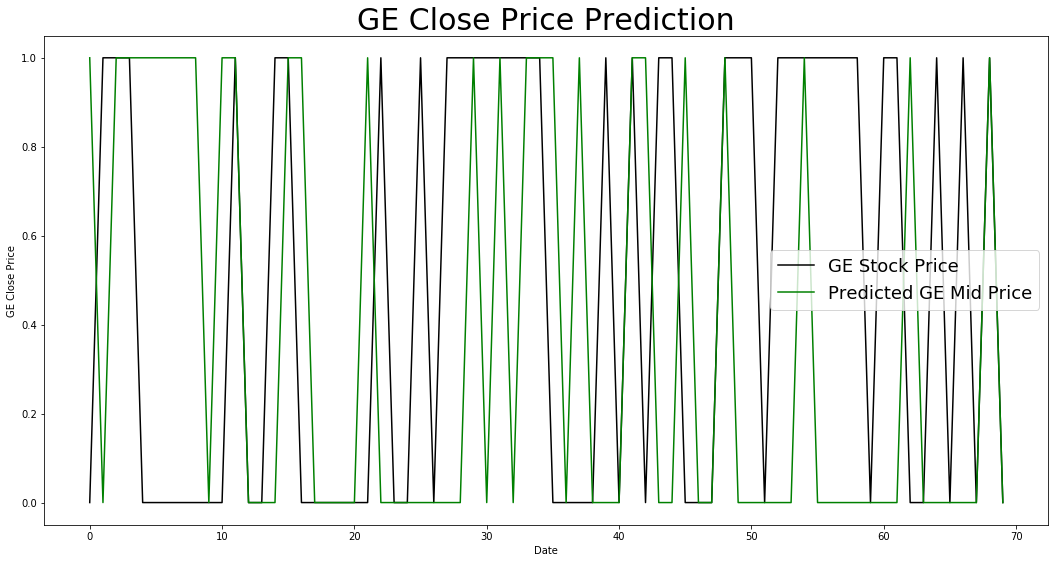

In [28]:
plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_baseline, color = 'green', label = 'Predicted GE Mid Price')
plt.title('GE Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Close Price')
plt.legend(fontsize=18)
plt.show()

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_score(y_test, predicted_stock_price_baseline)

0.4714285714285714

# 2. [LSTM + GRU]()

In [31]:
filepath="LSTM_GRU.hdf5"

In [32]:
model = Sequential()
model.add(GRU(256 , input_shape = (X_train.shape[1], X_train.shape[2]) , return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 256)           556032    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 1,097,922
Trainable params: 1,097,922
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam() , metrics = ['accuracy'])

In [34]:
history_lstm = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val), 
                    callbacks = [checkpoint , lr_reduce])

Train on 1180 samples, validate on 112 samples
Epoch 1/100
1180/1180 [==============================] - 13s 11ms/step - loss: 0.7113 - acc: 0.5364 - val_loss: 0.7004 - val_acc: 0.5000

Epoch 00001: val_loss improved from 0.71422 to 0.70041, saving model to 60-SEQ-30-PRED-1551300210
Epoch 2/100
1180/1180 [==============================] - 10s 9ms/step - loss: 0.7000 - acc: 0.5288 - val_loss: 0.7119 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.70041
Epoch 3/100
1180/1180 [==============================] - 11s 9ms/step - loss: 0.6900 - acc: 0.5347 - val_loss: 0.7136 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.70041
Epoch 4/100
1180/1180 [==============================] - 10s 9ms/step - loss: 0.6924 - acc: 0.5466 - val_loss: 0.7055 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.70041

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
1180/1180 [==============================] - 10s 9ms/step -

In [35]:
y_prob = model.predict(X_test) 
predicted_stock_price_gru = y_prob.argmax(axis=-1)

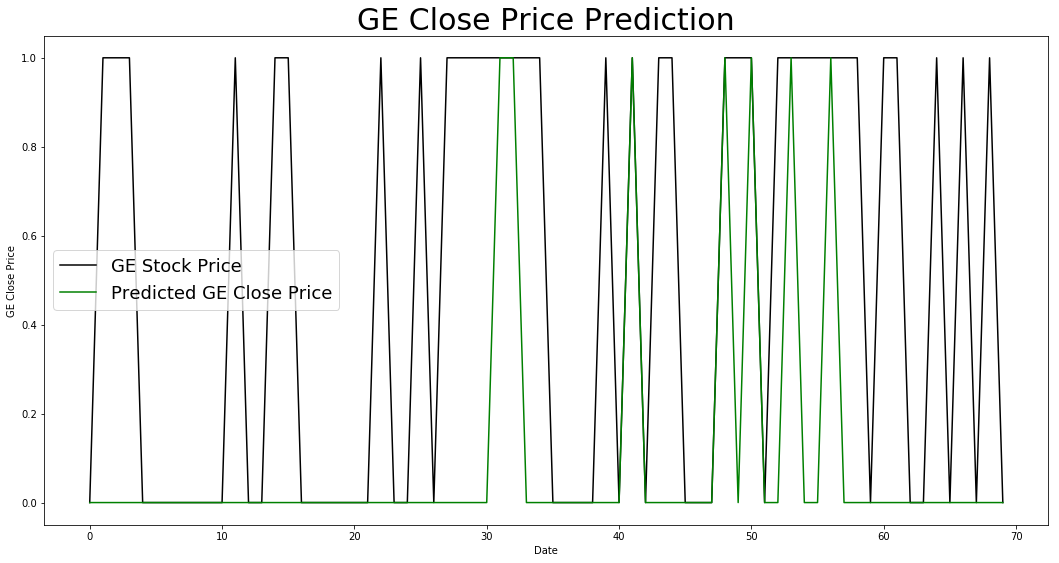

In [36]:
plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_gru, color = 'green', label = 'Predicted GE Close Price')
plt.title('GE Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Close Price')
plt.legend(fontsize=18)
plt.show()

In [37]:
accuracy_score(y_test, predicted_stock_price_gru)

0.6

# 3. [Attention]()

In [38]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from keras import backend as K
from keras.models import Model

In [39]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [40]:
inp = Input(shape = (X_train.shape[1], X_train.shape[2]))
x = LSTM(128, return_sequences=True)(inp)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Attention(SEQ_LEN)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)
model_lstm_attention = Model(inputs=inp, outputs=x)

In [41]:
model_lstm_attention.compile(loss='sparse_categorical_crossentropy', optimizer=Adam() , metrics = ['accuracy'])

model_lstm_attention.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 467)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 128)           305152    
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 128)           512       
_________________________________________________________________
attention_1 (Attention)      (None, 128)               188       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
__________

In [42]:
model_lstm_attention.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val), 
                    callbacks = [checkpoint , lr_reduce]
             )

Train on 1180 samples, validate on 112 samples
Epoch 1/100
1180/1180 [==============================] - 6s 5ms/step - loss: 0.6883 - acc: 0.5424 - val_loss: 0.7114 - val_acc: 0.5000

Epoch 00001: val_loss did not improve from 0.70041
Epoch 2/100
1180/1180 [==============================] - 4s 3ms/step - loss: 0.6872 - acc: 0.5373 - val_loss: 0.7300 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.70041
Epoch 3/100
1180/1180 [==============================] - 4s 3ms/step - loss: 0.6923 - acc: 0.5314 - val_loss: 0.6955 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.70041 to 0.69555, saving model to 60-SEQ-30-PRED-1551300210
Epoch 4/100
1180/1180 [==============================] - 4s 3ms/step - loss: 0.6887 - acc: 0.5356 - val_loss: 0.7029 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.69555
Epoch 5/100
1180/1180 [==============================] - 4s 3ms/step - loss: 0.6955 - acc: 0.4983 - val_loss: 0.6963 - val_acc: 0.5000

Epoch 00005: val_loss 

In [43]:
y_prob = model_lstm_attention.predict(X_test) 
predicted_stock_price_attention = y_prob.argmax(axis=-1)

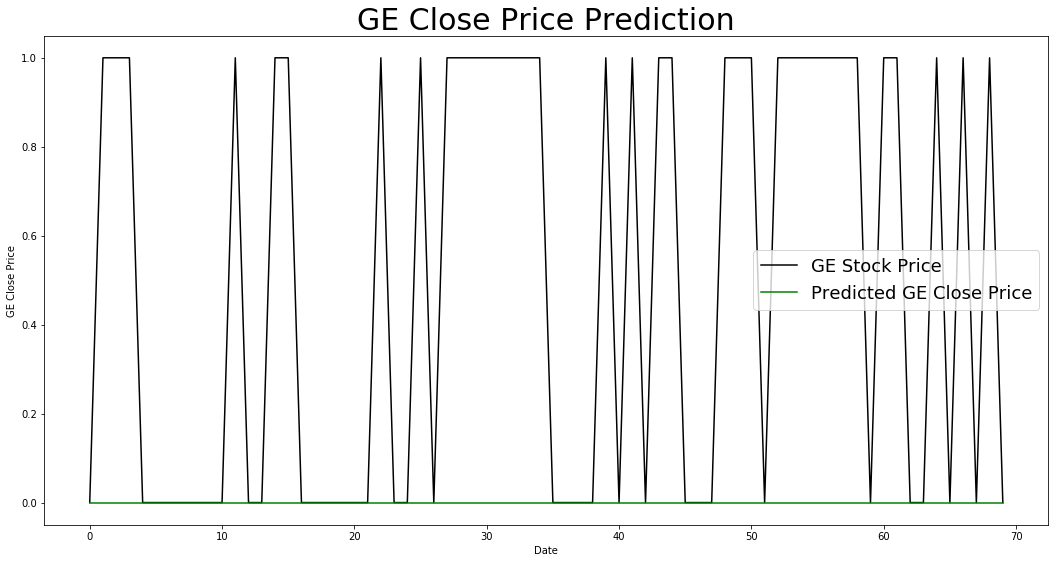

In [44]:
plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_attention, color = 'green', label = 'Predicted GE Close Price')
plt.title('GE Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Close Price')
plt.legend(fontsize=18)
plt.show()

In [45]:
accuracy_score(y_test, predicted_stock_price_attention)

0.5

 # [Multi-Head Attention]()

In [46]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(2, activation="softmax")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics=['accuracy'])

In [47]:
def build_model():
    inp = Input(shape = (X_train.shape[1], X_train.shape[2]))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="sigmoid")(conc)
    x = Dense(2, activation="softmax")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "binary_crossentropy", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "RMSprop",
        metrics=['accuracy'])
    
    return model

In [48]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=None)
y_val_cat = to_categorical(y_val, num_classes=None)
y_test_cat = to_categorical(y_test, num_classes=None)

In [49]:
multi_head = build_model()

In [50]:
multi_head.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60, 467)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 256)      610304      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 128)      164352      bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 60, 192)      24576       bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_7 (D

In [51]:
multi_head.fit(X_train, y_train_cat,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val_cat), 
                    callbacks = [checkpoint , lr_reduce]
             )

Train on 1180 samples, validate on 112 samples
Epoch 1/100
1180/1180 [==============================] - 20s 17ms/step - loss: 0.7413 - acc: 0.4966 - val_loss: 0.7027 - val_acc: 0.5000

Epoch 00001: val_loss did not improve from 0.69384
Epoch 2/100
1180/1180 [==============================] - 14s 12ms/step - loss: 0.6973 - acc: 0.5186 - val_loss: 0.6976 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.69384
Epoch 3/100
1180/1180 [==============================] - 14s 12ms/step - loss: 0.6861 - acc: 0.5703 - val_loss: 0.7032 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69384
Epoch 4/100
1180/1180 [==============================] - 14s 12ms/step - loss: 0.6864 - acc: 0.5381 - val_loss: 0.6981 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.69384
Epoch 5/100
1180/1180 [==============================] - 14s 12ms/step - loss: 0.6934 - acc: 0.5119 - val_loss: 0.7562 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.69384

Epoch 0

In [52]:
y_prob = multi_head.predict(X_test) 
predicted_stock_price_transformer = y_prob.argmax(axis=-1)

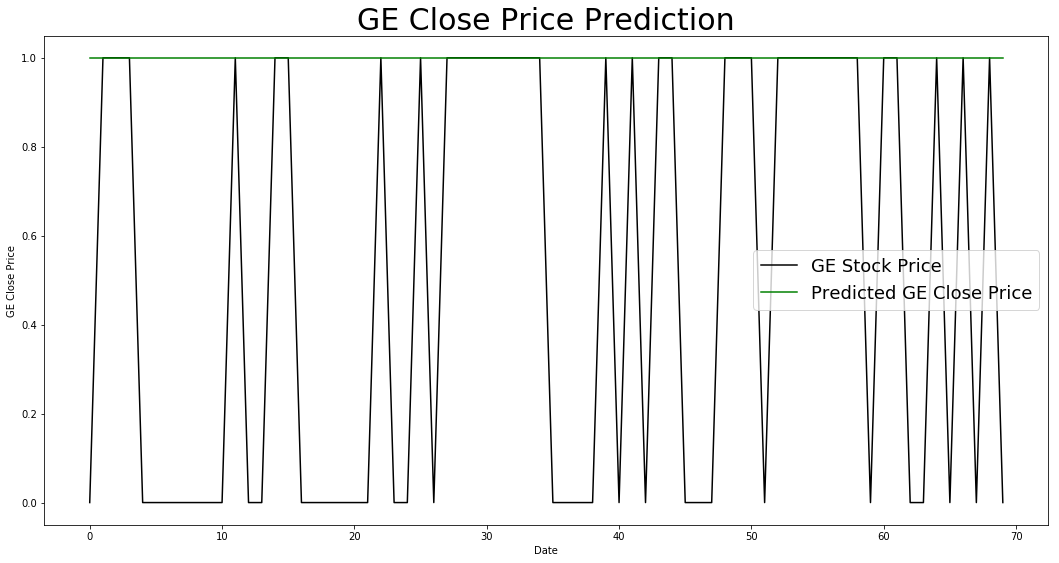

In [53]:
plt.figure(figsize = (18,9))
plt.plot(y_test, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_transformer, color = 'green', label = 'Predicted GE Close Price')
plt.title('GE Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('GE Close Price')
plt.legend(fontsize=18)
plt.show()

In [54]:
accuracy_score(y_test, predicted_stock_price_transformer)

0.5

# Work in progress, any suggestion for improvements is welcomed. 